In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
import time
import warnings
warnings.filterwarnings('ignore')
import importlib
from functions import *
from tqdm import tqdm
from netCDF4 import Dataset

In [2]:
# data load
ncfile = Dataset("../data/air.202010.nc")
air = np.squeeze(ncfile.variables['air'])
ncfile.close()
air = air[:,16,:252,1:337]
A = air
del air
N = A.shape
print('Dimension of A:', N)

In [5]:
# matrix unfoldings
A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
tmp = np.moveaxis(A,0,2) # 1 2 0
A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
tmp = np.moveaxis(A,2,0) # 2 0 1
A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])

In [6]:
# scree plot
scree = HOSVD_rank(A)

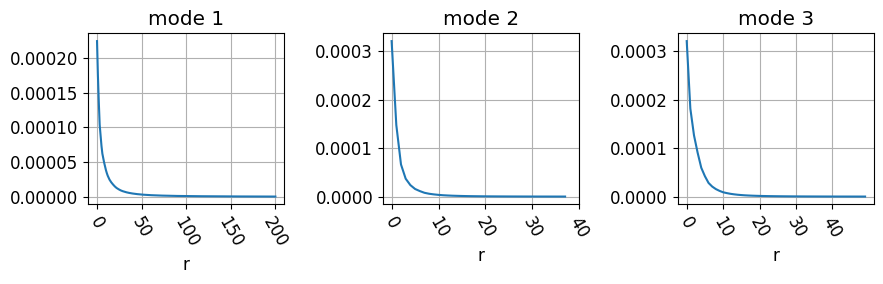

In [9]:
plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(scree[0])
ax[0].set_title('mode 1')
ax[0].set_xlabel('r')
ax[0].set_xticks(np.arange(0, N[0], 50))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-60)
ax[0].grid()

ax[1].plot(scree[1])
ax[1].set_title('mode 2')
ax[1].set_xlabel('r')
ax[1].set_xticks(np.arange(0, 50, 10))
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-60)
ax[1].grid()

ax[2].plot(scree[2])
ax[2].set_title('mode 3')
ax[2].set_xlabel('r')
ax[2].set_xticks(np.arange(0, 50, 10))
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=-60)
ax[2].grid()
plt.tight_layout()
#plt.savefig('../plots/air_screes.png',dpi=300)
plt.show()

In [10]:
# set the rank
r = np.array([50,10,20])

In [10]:
errs = []
times = []
for i in tqdm(range(100)):
    RP_HOSVD_err, RP_HOSVD_time = RP_HOSVD(A,A0,A1,A2,r)
    RP_STHOSVD_err, RP_STHOSVD_time = RP_STHOSVD(A,A0,A1,A2,r)
    R_PET_err, R_PET_time = R_PET(A,A0,A1,A2,r)
    R_ST_err, R_ST_time = R_ST(A,A0,A1,A2,r)
    R_HOID_err, R_HOID_time = R_HOID(A,A0,A1,A2,r)
    RP_HOOI_err, RP_HOOI_time = RP_HOOI(A,r,tol=10)
    R_SCTT_err, R_SCTT_time = R_SCTT(A,r,0.5)
    _, R_SCT_err, R_SCT_time = Random_SketchyCoreTucker(A,A0,A1,A2,r,400)
    _, P_SCT_err, m, P_SCT_time = pgSketchyCoreTucker(A,A0,A1,A2,r,10,10,400)
    errs.append([RP_HOSVD_err,RP_STHOSVD_err,R_PET_err,R_ST_err,R_HOID_err,RP_HOOI_err,R_SCTT_err,R_SCT_err,P_SCT_err])
    times.append([RP_HOSVD_time,RP_STHOSVD_time,R_PET_time,R_ST_time,R_HOID_time,RP_HOOI_time,R_SCTT_time,R_SCT_time,P_SCT_time])
errs = np.array(errs)
times = np.array(times)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [49:26<00:00, 29.67s/it]


In [11]:
print(np.mean(errs,axis=0))
print(np.std(errs,axis=0))
print(np.mean(times,axis=0))
print(np.std(times,axis=0))

[3.25092460e-05 8.15325530e-05 3.94531348e+00 4.61664088e-04
 2.10879119e-05 2.39262117e-05 2.07066454e-01 9.69625207e-02
 2.31957057e-05]
[1.43619805 3.77184273 2.87521402 0.23172076 3.03697968 2.73950964
 7.43547814 1.60287928 2.75112567]


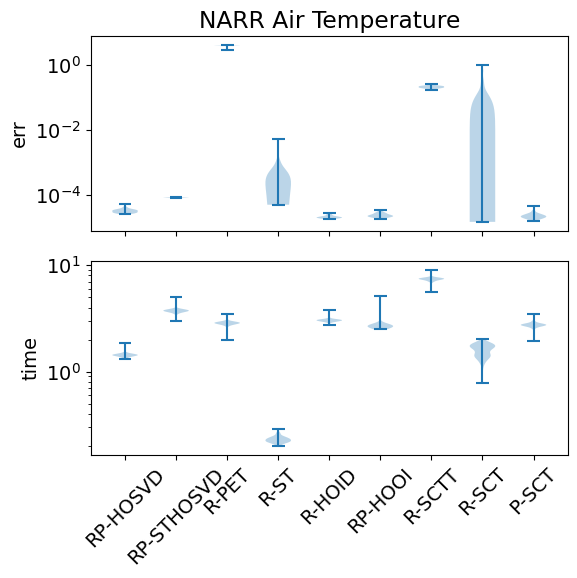

In [14]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(2,1,figsize=[6,6])
ax[0].violinplot(errs,vert=True)
ax[0].set_yscale('log')
ax[0].set_ylabel('err')
ax[0].set_xticks(range(1,10))
ax[0].set_xticklabels([])
ax[0].set_title('NARR Air Temperature')
ax[1].violinplot(times,vert=True)
ax[1].set_yscale('log')
ax[1].set_ylabel('time')
ax[1].set_xticks(range(1,10))
ax[1].set_xticklabels(['RP-HOSVD','RP-STHOSVD','R-PET','R-ST','R-HOID','RP-HOOI','R-SCTT','R-SCT','P-SCT'],rotation=45)
plt.tight_layout()
#plt.savefig('../plots/air_error_AISTATS.png',dpi=300)
plt.show()

# Learning Curve

In [16]:
logPS_0, logPS_1, logPS_2 = pgskt_log(A,r,10,10,500)
err_logPS = lc(N,A,A0,A1,A2,r,logPS_0,logPS_1,logPS_2)

In [17]:
logRS_0, logRS_1, logRS_2 = rdskt_log(A,r,10,10,500)
err_logRS = lc(N,A,A0,A1,A2,r,logRS_0,logRS_1,logRS_2)

In [18]:
nf_PS = [len(i)+len(j)+len(k) for i,j,k in zip(logPS_0,logPS_1,logPS_2)]
nf_RS = [len(i)+len(j)+len(k) for i,j,k in zip(logRS_0,logRS_1,logRS_2)]

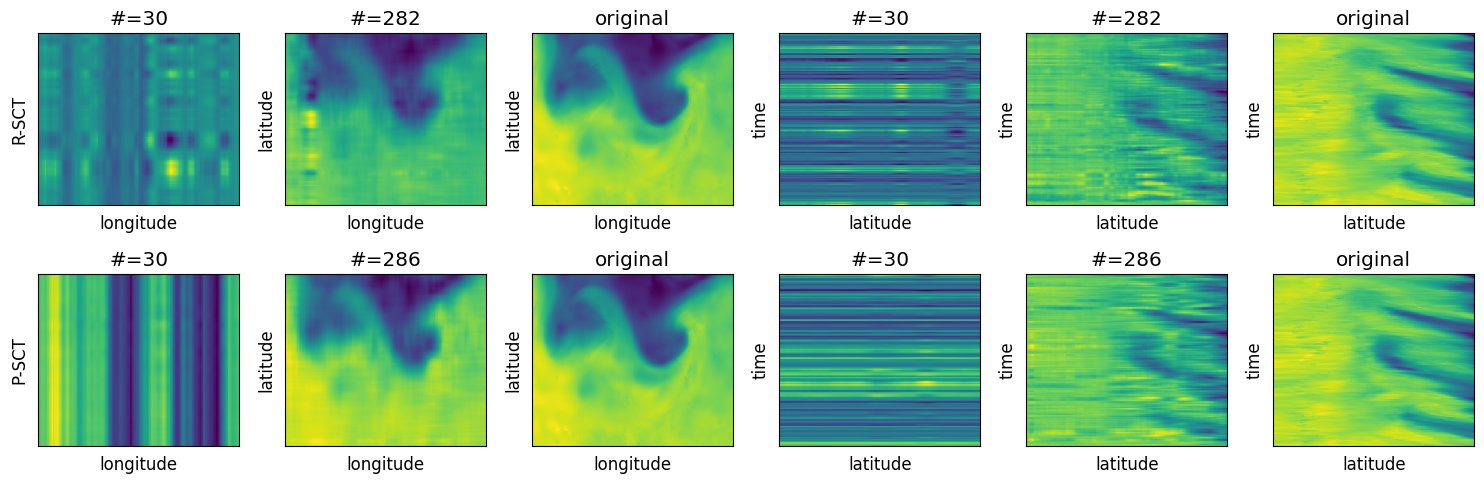

In [19]:
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots(2,6,figsize=[15,5])

ax[0,0].pcolormesh(Ahat(N,A,A0,A1,A2,r,logRS_0[0],logRS_1[0],logRS_2[0])[0,:,:])
ax[0,1].pcolormesh(Ahat(N,A,A0,A1,A2,r,logRS_0[30],logRS_1[30],logRS_2[30])[0,:,:])
ax[0,0].set_title('#=' + str(nf_RS[0]))
ax[0,1].set_title('#=' + str(nf_RS[30]))

ax[1,0].pcolormesh(Ahat(N,A,A0,A1,A2,r,logPS_0[0],logPS_1[0],logPS_2[0])[0,:,:])
ax[1,1].pcolormesh(Ahat(N,A,A0,A1,A2,r,logPS_0[30],logPS_1[30],logPS_2[30])[0,:,:])
ax[1,0].set_title('#=' + str(nf_PS[0]))
ax[1,1].set_title('#=' + str(nf_PS[30]))

ax[0,2].pcolormesh(A[0,:,:])
ax[1,2].pcolormesh(A[0,:,:])
ax[0,2].set_title('original')
ax[1,2].set_title('original')

ax[0,3].pcolormesh(Ahat(N,A,A0,A1,A2,r,logRS_0[0],logRS_1[0],logRS_2[0])[:,:,0])
ax[0,4].pcolormesh(Ahat(N,A,A0,A1,A2,r,logRS_0[30],logRS_1[30],logRS_2[30])[:,:,0])
ax[0,3].set_title('#=' + str(nf_RS[0]))
ax[0,4].set_title('#=' + str(nf_RS[30]))

ax[1,3].pcolormesh(Ahat(N,A,A0,A1,A2,r,logPS_0[0],logPS_1[0],logPS_2[0])[:,:,0])
ax[1,4].pcolormesh(Ahat(N,A,A0,A1,A2,r,logPS_0[30],logPS_1[30],logPS_2[30])[:,:,0])
ax[1,3].set_title('#=' + str(nf_PS[0]))
ax[1,4].set_title('#=' + str(nf_PS[30]))

ax[0,5].pcolormesh(A[:,:,0])
ax[1,5].pcolormesh(A[:,:,0])
ax[0,5].set_title('original')
ax[1,5].set_title('original')

for i, axis in enumerate(ax.ravel()):
    axis.set_xticks([])
    axis.set_yticks([])
    if i%6 < 3:
        axis.set_xlabel('longitude')
        axis.set_ylabel('latitude')
    else:
        axis.set_xlabel('latitude')
        axis.set_ylabel('time')

ax[0,0].set_ylabel('R-SCT')
ax[1,0].set_ylabel('P-SCT')

plt.tight_layout()
#plt.savefig('../plots/air_Ar_AISTATS.png',dpi=300)
plt.show()